## Task

In this HW, you will to do image in-painting using autoencoders.

Image In-painting is a task where you give a corrupted or incomplete image as an input and the output is the completed image.

We will do image in-painting on CIFAR10 dataset. The code below can help you generate random corrupted images.

Your task is to construct and train an autoencoder on this dataset for image in-painting. Finally as evaluation, show 10 random examples from testset and how your model performs on them.


Hint: Using a u-net like structure might help.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import seaborn as sns
from tqdm import tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class Dataset(torchvision.datasets.CIFAR10):
    def __init__(self, path, image_dims = (32, 32), n_channels = 3, train = True):
        super().__init__(path, train, download = True)
        self.n_classes = 10
        self.image_dims = image_dims
        self.n_channels = n_channels
        self.resize = transforms.Resize(image_dims)
        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, index):
        image, label = super().__getitem__(index)

        Y_output = self.resize(image)
        X_input, X_mask = self.Create_Mask(Y_output)
        return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output)

    def Create_Mask(self, image):
        mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype = np.uint8)

        for _ in range(np.random.randint(1, 10)):
            x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])
            y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])
            thickness = np.random.randint(1, 3)

            cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

        image = np.asarray(image)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image, mask

In [11]:
Trainset = Dataset('./data')
Testset = Dataset('./data', train=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
def show_imgs(masked_image, mask, original_image):
    f, axs = plt.subplots(1,3)
    axs[0].imshow(np.transpose(masked_image.numpy(), (1,2,0)))
    axs[0].set_title("Masked Image")
    axs[1].imshow(np.transpose(mask.numpy(), (1,2,0)))
    axs[1].set_title("Mask")
    axs[2].imshow(np.transpose(original_image.numpy(), (1,2,0)))
    axs[2].set_title("Original Image")

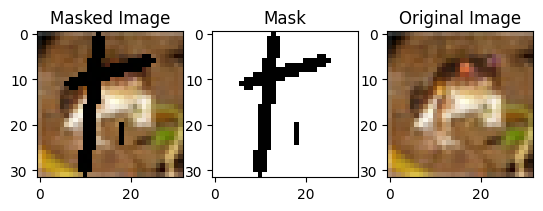

In [13]:
show_imgs(*Trainset[0])

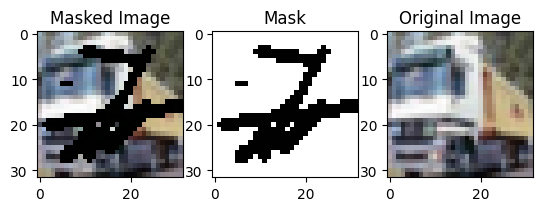

In [14]:
show_imgs(*Trainset[1])

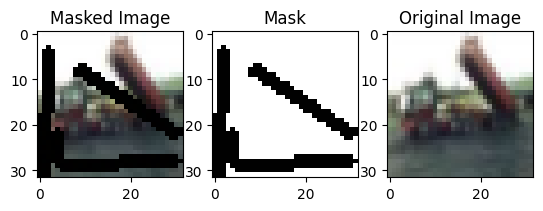

In [15]:
show_imgs(*Trainset[2])

In [16]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(Trainset, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(Testset, batch_size = batch_size, shuffle = False)

## UNet

### UNet model architecture:

![UNet](https://miro.medium.com/v2/resize:fit:1400/1*f7YOaE4TWubwaFF7Z1fzNw.png)

In [17]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [18]:
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block1 = conv_block(in_channels, out_channels)
        self.conv_block2 = conv_block(out_channels, out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x1 = self.conv_block1(x)
        x2 = self.conv_block2(x1)
        x3 = self.maxpool(x2)
        return x3, x2

In [19]:
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.trans_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, padding=0, stride=2)
        self.conv_block1 = conv_block(in_channels, out_channels)
        self.conv_block2 = conv_block(out_channels, out_channels)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x, enc, dropout=False):
        x = self.trans_conv(x)
        x = torch.cat([x, enc], dim=1)
        if dropout: x = self.dropout(x)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        return x

In [20]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = encoder(3, 64)
        self.enc2 = encoder(64, 128)
        self.enc3 = encoder(128, 256)
        self.enc4 = encoder(256, 512)

        self.bottleneck = nn.Sequential(
            conv_block(512, 1024),
            conv_block(1024, 1024)
        )

        self.dec1 = decoder(1024, 512)
        self.dec2 = decoder(512, 256)
        self.dec3 = decoder(256, 128)
        self.dec4 = decoder(128, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=1, padding=0)

    def forward(self, x):
        x, enc1 = self.enc1(x)
        x, enc2 = self.enc2(x)
        x, enc3 = self.enc3(x)
        x, enc4 = self.enc4(x)

        x = self.bottleneck(x)

        x = self.dec1(x, enc4, dropout=True)
        x = self.dec2(x, enc3, dropout=True)
        x = self.dec3(x, enc2, dropout=True)
        x = self.dec4(x, enc1, dropout=True)

        x = self.final(x)

        return x

## Training

In [21]:
# Defining the training function
def train(model, epochs, optimizer, criterion, device, scheduler=None):
    # Lists to keep track of the losses for plotting later
    val_losses = []
    train_losses = []

    # Iterating over epochs
    for epoch_num in range(epochs):
        model.train() # Sets the model in training mode

        epoch_losses = 0

        # Looping over batches for each epoch
        for batch_x, batch_mask, batch_y in tqdm(train_loader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_preds = model(batch_x) # Forward pass

            loss = criterion(batch_y_preds, batch_y) # Calculating the loss per batch

            optimizer.zero_grad()
            loss.backward() # Backwards pass
            optimizer.step() # Updating parameters

            epoch_losses += (len(batch_y)*loss.item()) # Keeping track of the losses per batch

        epoch_loss = epoch_losses/len(train_loader)
        train_losses.append(epoch_loss) # Keeping training track of the loss per epoch

        model.eval() # Sets the model in evaluation mode for validation
        correctly_labelled = 0
        with torch.no_grad(): # Disables gradient calculation
            val_epoch_losses = 0
            for val_batch_x, val_batch_mask, val_batch_y in tqdm(val_loader):
                val_batch_x = val_batch_x.to(device)
                val_batch_y = val_batch_y.to(device)

                val_batch_y_preds = model(val_batch_x) # Predictions
                val_loss = criterion(val_batch_y_preds, val_batch_y)
                val_epoch_losses += (len(val_batch_y)*val_loss.item())

            val_epoch_loss = val_epoch_losses/len(val_loader)
            val_losses.append(val_epoch_loss) # Tracking epoch validation loss

        if scheduler:
            scheduler.step() # Updating the learning rate scheduler if one was provided
            print(f'Epoch: {epoch_num+1}/{epochs}, learning_rate={optimizer.param_groups[0]["lr"]:.6f} train_loss={epoch_loss:.4f}, val_loss={val_epoch_loss:.4f}.')
        else:
            print(f'Epoch: {epoch_num+1}/{epochs}, train_loss={epoch_loss:.4f}, val_loss={val_epoch_loss:.4f}.')
        print()
    print('Training Done')
    return train_losses, val_losses # Returns the losses in order to keep track of them

In [28]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)

lr=3e-4
weight_decay=1e-2
num_epochs=5
criterion=nn.MSELoss()

optimizer=optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [29]:
%%time

# Training the model
train_losses = []
val_losses = []

cycle_train_losses, cycle_val_losses = train(model, num_epochs, optimizer, criterion, device, scheduler=None)

train_losses += cycle_train_losses
val_losses += cycle_val_losses

100%|██████████| 157/157 [00:12<00:00, 12.84it/s]


Epoch: 1/5, train_loss=0.6686, val_loss=0.2720.



100%|██████████| 157/157 [00:12<00:00, 12.95it/s]


Epoch: 2/5, train_loss=0.2581, val_loss=0.5026.



100%|██████████| 157/157 [00:11<00:00, 13.35it/s]


Epoch: 3/5, train_loss=0.2345, val_loss=0.2661.



100%|██████████| 157/157 [00:11<00:00, 13.36it/s]


Epoch: 4/5, train_loss=0.2315, val_loss=0.5091.



100%|██████████| 157/157 [00:12<00:00, 12.67it/s]

Epoch: 5/5, train_loss=0.2385, val_loss=0.4331.

Training Done
CPU times: user 11min 50s, sys: 7.51 s, total: 11min 58s
Wall time: 9min 7s


In [30]:
# Function to plot the training losses and validation losses vs epochs. This will help identify overfitting and model performance
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Cross Entropy)')
    plt.legend()
    plt.show()

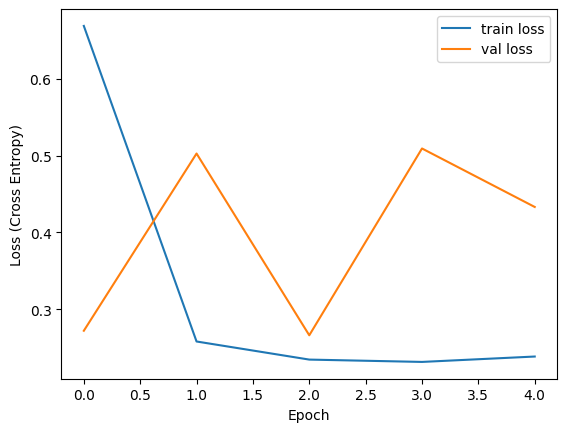

In [31]:
plot_losses(train_losses, val_losses)

## Results

In [32]:
def plot_images(raw, masked, predicted):
    plt.figure(figsize=(15,15))
    
    plt.subplot(1,3,1)
    plt.title('Raw Image', color = 'green', fontsize = 20)
    plt.imshow(raw)
    
    plt.subplot(1,3,2)
    plt.title('Masked Image', color = 'black', fontsize = 20)
    plt.imshow(masked)
    
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

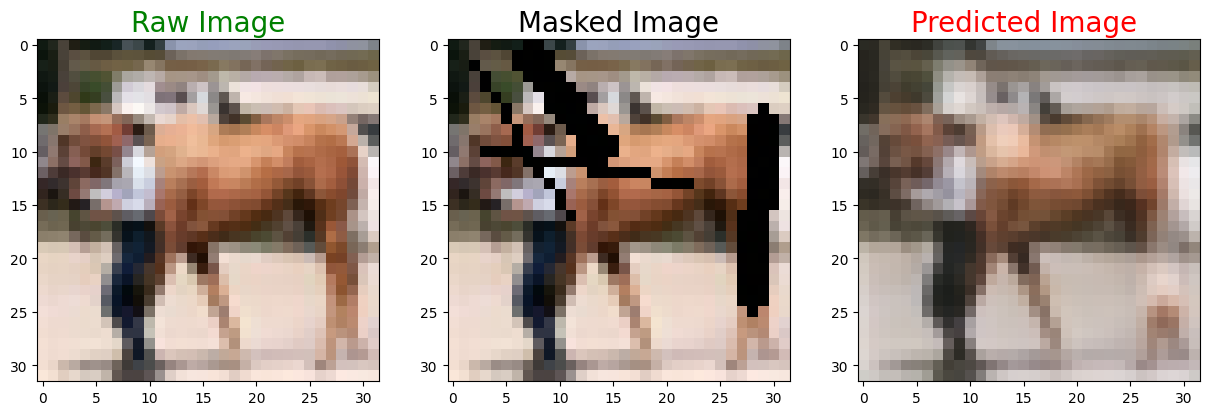

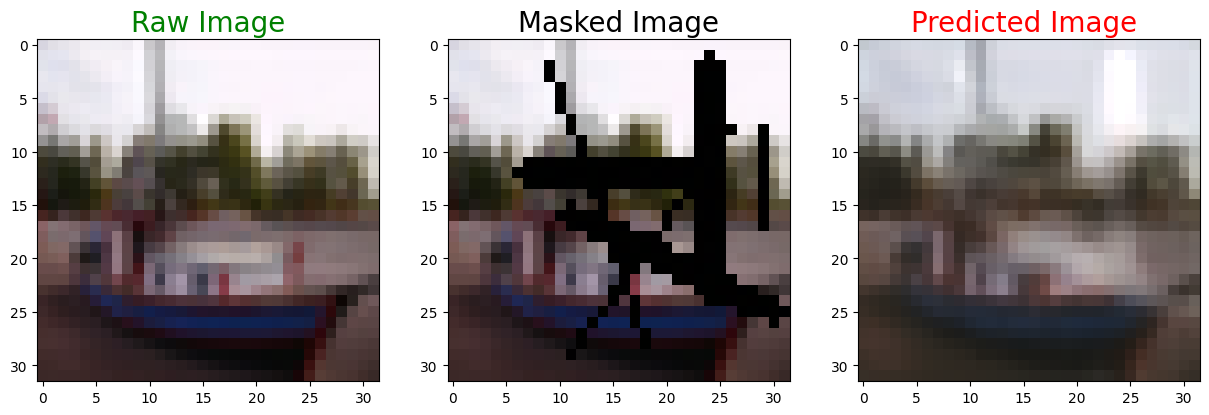

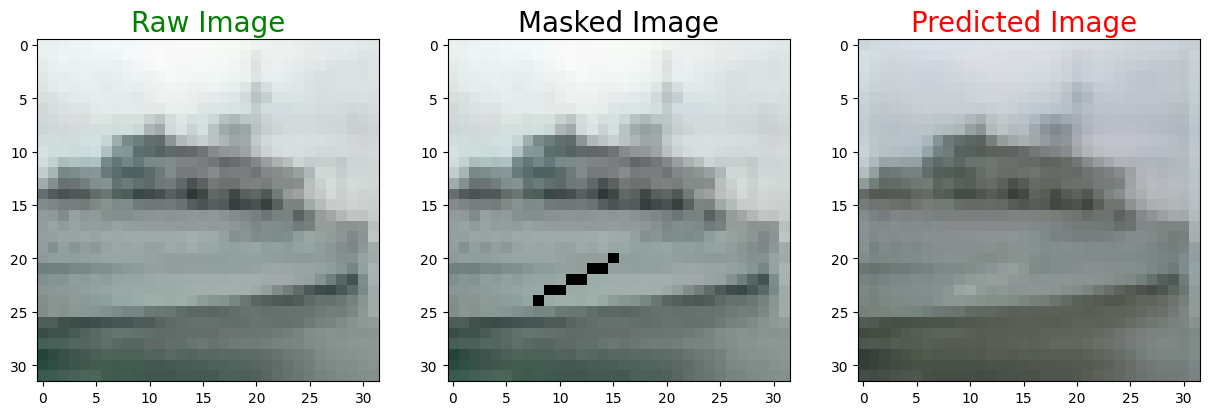

In [37]:
for _ in range(3):
    idx = np.random.randint(0, len(Testset))
    masked, mask, raw = Testset[idx]
    predicted = model(masked.unsqueeze(0).to(device))[0].cpu().detach()

    plot_images(raw.permute(1, 2, 0), masked.permute(1, 2, 0), predicted.permute(1, 2, 0))